In [491]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io.wavfile import write, read
import math
from pychord import Chord
from pychord import find_chords_from_notes

In [492]:
def freq_to_note(freq):
    notes = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]

    A_freq = 440

    note_number = 12 * math.log2(freq / A_freq) + 49
    note_number = round(note_number)

    note_index = (note_number - 1) % len(notes)
    note = notes[note_index]

    octave = (note_number + 8) // len(notes)

    return list([note, octave, round(freq), note_index])

In [493]:
def freqs_to_chord(freqs):
    return

In [494]:
# fs = 44100  # Sample rate
# signal = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
# sd.wait()

In [495]:
seconds = 18.559  # Duration of recording
# a, signal = read("./test_audio/cminor7.wav")  # C Db Bb G con C la nota di frequenza minore
a, signal = read("./test_audio/dmajor.wav")
signal = (signal[:, 0] + signal[:, 1]) / 2  # Convert audio to mono
n_samples = signal.shape[0]
dT = seconds / n_samples  # Sample spacing

C:\Users\Simone\AppData\Local\Temp\ipykernel_16124\4292418009.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  a, signal = read("./test_audio/dmajor.wav")


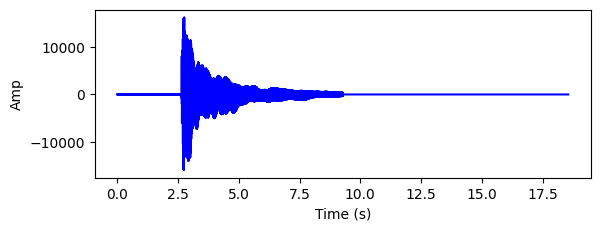

In [496]:
# plot signal versus time
t_array = np.linspace(0, seconds, n_samples)
plt.subplot(2, 1, 1)
plt.plot(t_array, signal, "b-")
plt.ylabel("Amp")
plt.xlabel("Time (s)")
plt.show()

FFT of the signal 

In [497]:
fft_signal = fft(signal)
fft_amp = np.abs(fft_signal)[: n_samples // 2]
fft_freq = fftfreq(n_samples, dT)[: n_samples // 2]

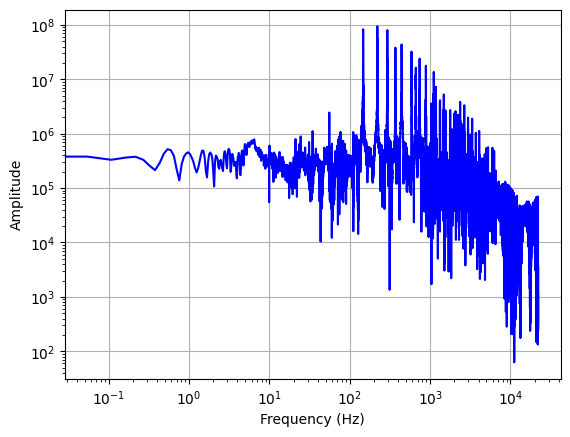

In [498]:
# plotting
fig, ax = plt.subplots()
plt.plot(fft_freq, fft_amp, "b-", label="Audio Signal")
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.show()

Peak detection and notes search

In [499]:
n_peaks = 6  # Number of peak to detect
peak_size = 200  # Size in indexes of the peak

notes = []

for i in range(0, n_peaks):
    max_index = np.argmax(fft_amp)
    max_amp = fft_amp[max_index]
    notes.append(freq_to_note(fft_freq[max_index]))
    notes[i].append(max_amp)

    fft_amp[
        max_index - peak_size : max_index + peak_size
    ] = 0  # Remove peak from the next max search

Remove notes with amp way above the amp mean or impossible frequencies

In [500]:
amp_mean = 0

# Max and Min freq on a piano
min_freq = 15
max_freq = 8000

for i in range(len(notes)):
    amp_mean += notes[i][4] / len(notes)

j = 1
for i in range(1, len(notes)):
    if (
        (notes[j][4] < amp_mean * 0.5)
        or (notes[j][2] < min_freq)
        or (notes[j][2] > max_freq)
    ):
        del notes[j]
    else:
        j = j + 1

print(notes)

[['A', 3, 220, 0, 94002530.52777125], ['D', 3, 147, 5, 83042425.58562611], ['D', 4, 293, 5, 80075524.66597334], ['A', 4, 441, 0, 43635545.79834571], ['F#', 4, 370, 9, 38130610.54388505], ['D', 5, 586, 5, 32262089.87085646]]
[['A', 3, 220, 0, 94002530.52777125], ['D', 3, 147, 5, 83042425.58562611], ['D', 4, 293, 5, 80075524.66597334], ['A', 4, 441, 0, 43635545.79834571], ['F#', 4, 370, 9, 38130610.54388505], ['D', 5, 586, 5, 32262089.87085646]]


Sort notes base on alphabetic order

In [501]:
def right_rotate_list(list, n):
    for i in range(n):
        list.insert(0, list.pop())
    return list


# Sort notes alphabetically
notes.sort(key=lambda a: a[3])

# Find the root note with the lower frequencies which is also the first of a possible series of equal notes
root_note_index = np.argmin(list(zip(*notes))[2])

# Rotate the note keeping the alphabetical order but with root note on index 0
if root_note_index != 0:
    notes = right_rotate_list(notes, len(notes) - root_note_index)

print(notes)

[['D', 3, 147, 5, 83042425.58562611], ['D', 4, 293, 5, 80075524.66597334], ['D', 5, 586, 5, 32262089.87085646], ['F#', 4, 370, 9, 38130610.54388505], ['A', 3, 220, 0, 94002530.52777125], ['A', 4, 441, 0, 43635545.79834571]]


Remove duplicated notes

In [502]:
last_note = notes[0][0]

j = 1
for i in range(1, len(notes)):
    if notes[j][0] == last_note:
        del notes[j]
    else:
        last_note = notes[j][0]
        j = j + 1

print(notes)

[['D', 3, 147, 5, 83042425.58562611], ['F#', 4, 370, 9, 38130610.54388505], ['A', 3, 220, 0, 94002530.52777125]]


Find chords based on the finded notes

In [503]:
chords = find_chords_from_notes(list(zip(*notes))[0])
print(chords)

[<Chord: D>]
